<h1><font color="#113D68" size=6>Deep Learning Avanzado con Python y Keras</font></h1>
<h1><font color="#113D68" size=5>Leandro Martín Rognoni</font></h1>

<br><br>
<div style="text-align: right">
 
</div>

<a id="section0"></a>
# <font color="#004D7F" size=5> Contexto</font>

* Entrenamiento de una red
* Capas de la red
* Carga de grandes bases de datos
* Data augmentation

* VGG 102 Category Flowers: la base de datos utilizada en las prácticas anteriores, que consiste en un problema de clasificación de imágenes y con el que veremos redes con capas más complejas, como cargar grandes bases de datos y el data augmentation.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import keras

%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# Establecemos una semilla para numpy y tensorflow para poder reproducir la ejecución y los resultados
SEED = 1000
np.random.seed(SEED)
tf.random.set_seed(SEED)

<a id="section3.1"></a>
# <font color="#004D7F" size=5> VGG 102 Category Flowers</font>

Es un problema de clasificación de imágenes donde la clase es una de las 102 posibles etiquetas que representan flores que aparecen en la foto.

In [2]:
import sys
import time
import urllib.request
import tarfile

progress_size = 0  # Declaración global de la variable progress_size

def reporthook(count, block_size, total_size):
    global start_time, progress_size
    if count == 0:
        start_time = time.time()
        progress_size = 0  # Inicializar progress_size en 0 al inicio
        return
    duration = time.time() - start_time
    if duration == 0:
        speed = 0
    else:
        progress_size = int(count * block_size)
        speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

# Download and extract
data_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
urllib.request.urlretrieve(data_url, 'vgg102flowers.tar.gz', reporthook)
tar = tarfile.open('vgg102flowers.tar.gz', "r:gz")
tar.extractall()
tar.close()

labels_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
urllib.request.urlretrieve(labels_url, 'vgg102flowers_targets.mat', reporthook)

...72%, 239 MB, 7329 KB/s, 33 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...91%, 299 MB, 7529 KB/s, 40 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...1631%, 0 MB, 2666 KB/s, 0 seconds passeded

('vgg102flowers_targets.mat', <http.client.HTTPMessage at 0x27efd6a1390>)

In [3]:
 
import numpy as np
from glob import glob
from scipy.io import loadmat
# Files
files = np.array(sorted(glob("jpg/*")))

# Targets
mat = loadmat('vgg102flowers_targets.mat')
labels = mat['labels'][0] - 1

# Random permute (we can also shuffle the dataset)
idx = np.random.permutation(len(files))
files = files[idx]
labels = labels[idx]

# Load classes names
# From: https://github.com/jimgoo/caffe-oxford102
names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

print("Loaded %d files." % len(files))

Loaded 8189 files.


In [4]:
from sklearn.model_selection import train_test_split

# Train/valid/test split
train_valid_files, test_files, train_valid_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, random_state=1234, stratify=labels)

train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_valid_files, train_valid_labels, test_size=0.25, random_state=5678, stratify=train_valid_labels)

print("Train: ", train_files.shape)
print("Valid: ", valid_files.shape)
print("Test: ", test_files.shape)

del train_valid_files, train_valid_labels

Train:  (4913,)
Valid:  (1638,)
Test:  (1638,)


Ahora vamos a utilizar las funciones de **Keras** para preparar un iterador que recorra las imágenes de la carpeta y así poder entrenar nuestra red neuronal. Extisten varias opciones para realizar este iterador, así como formas de hacer data augmentation y de extender dichas opciones a las predefinidas en Keras.

En este caso vamos a empezar leyendo de un DataFrame de pandas con dos columnas, una con la ruta a la imagen y otra con la etiqueta correspondiente. Todo esto lo haremos a través de la clase `ImageDataGenerator`, que se divide en dos partes como veremos a continuación.

In [5]:
import pandas as pd


train_frame = pd.DataFrame(np.array([train_files, train_labels]).T, columns=['files','labels'])
valid_frame = pd.DataFrame(np.array([valid_files, valid_labels]).T, columns=['files','labels'])
test_frame = pd.DataFrame(np.array([test_files, test_labels]).T, columns=['files','labels'])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# cuando definimos ImageDataGenerator incluimos los preprocesamientos a realizar
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# y con esta indicamos como vamos a leer la información y de donde.
train_iter = train_datagen.flow_from_dataframe(train_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(100, 120), 
                                               class_mode='categorical',
                                               batch_size=512, 
                                               shuffle=True)

valid_iter = valid_datagen.flow_from_dataframe(valid_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(100, 120), 
                                               class_mode='categorical',
                                               batch_size=512, 
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame, 
                                             x_col='files', 
                                             y_col='labels', 
                                             target_size=(100, 120), 
                                             class_mode='categorical',
                                             batch_size=512, 
                                             shuffle=False)

Found 4913 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


<a id="section3.2"></a>
# <font color="#004D7F" size=5> Red Convolucional</font>

 
* 1 o varios bloques convolucionales compuestos, que incluye:
* 1 o varias capas convolucionales, todas con activación ReLU
* 1 capa Max Pooling
* 1 o varias capas densas o `Fully connected` con activación ReLU
* 1 capa de salida con softmax

 

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# definimos el modelo lineal
model = Sequential()

# recordemos que en la primera capa hay que indicar el tamaño de la entrada
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Antes de poder pasar de la capa convolucional a la densa, es necesario "aplanar" la salida, por eso se usa Flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# finalmente creamos la capa de salida, con el tamaño de las etiquetas de nuestro problema
model.add(Dense(102, activation='softmax'))

C:\Users\Lea\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Antes de continuar, vamos a ver unas funciones de Keras especialmente útiles para ver ciertos aspectos de las redes.

<a id="section3.2.1"></a>
## <font color="#004D7F" size=4>summary</font>
Esta función nos muestra una tabla con las capas que forman nuestra red, asi como su tamaño y el número de parámetros a entrenar por capa.

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 116, 32)    │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    38,929,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │       104,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,087,654 (149.11 MB)

 Trainable params: 39,087,654 (149.11 MB)

 Non-trainable params: 0 (0.00 B)

<a id="section3.2.2"></a>
## <font color="#004D7F" size=4>get_config</font>
Esta función nos devuelve la configuración de una red, en una estructura de diccionario y que se puede utilizar para inicializar otros modelos. 

In [50]:
model.get_config()

{'name': 'sequential_6',
 'trainable': True,
 'dtype': 'float32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 100, 120, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer_6'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_14',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (5, 5),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': N

<a id="section3.3"></a>
# <font color="#004D7F" size=5>Entrenamiento y validación</font>

En este punto vamos a entrenar la red igual que hicimos en el problema de MNIST. Como estamos trabajando con un iterador, deberemos llamar a la función `fit_generator`, que se encarga de realizar el mismo proceso que `fit` pero con un generador. Además, deberemos indicar el numero de pasos o `steps` que tiene una `epoch`. Esto es, el número total de imágenes entre el tamaño del batch.

In [9]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    #staircase=True,
    decay_rate=1e-6)

In [10]:
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])


history = model.fit(train_iter, steps_per_epoch = train_frame.shape[0]//train_iter.batch_size,
                              epochs=10, validation_data=valid_iter, 
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/10


C:\Users\Lea\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - acc: 0.0252 - loss: 4.6382 - val_acc: 0.0319 - val_loss: 4.6051
Epoch 2/10
1/9 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - acc: 0.0230 - loss: 4.6357

C:\Users\Lea\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - acc: 0.0230 - loss: 4.6357 - val_acc: 0.0000e+00 - val_loss: 4.6745
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - acc: 0.0232 - loss: 4.6765 - val_acc: 0.0326 - val_loss: 4.6052
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.0273 - loss: 4.6055 - val_acc: 0.0196 - val_loss: 4.6100
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - acc: 0.0326 - loss: 10.9437 - val_acc: 0.0319 - val_loss: 4.5964
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.0156 - loss: 4.6008 - val_acc: 0.0098 - val_loss: 4.5965
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - acc: 0.0330 - loss: 4.5882 - val_acc: 0.0319 - val_loss: 4.5718
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.0430 - loss: 4.5677 - val_acc: 0.0098 - val_loss: 4.5806
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - acc: 0.0287 - loss: 4.5664 - val_acc: 0.0319 - val_loss: 4.5469
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc: 0.0430 - loss: 4.5416 - val_acc: 

In [11]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - acc: 0.0328 - loss: 4.5435
loss en validación: 4.544000625610352 
accuracy en validación: 0.0319010429084301
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - acc: 0.0293 - loss: 4.5423
loss en test: 4.547520160675049 
accuracy en test: 0.029296875


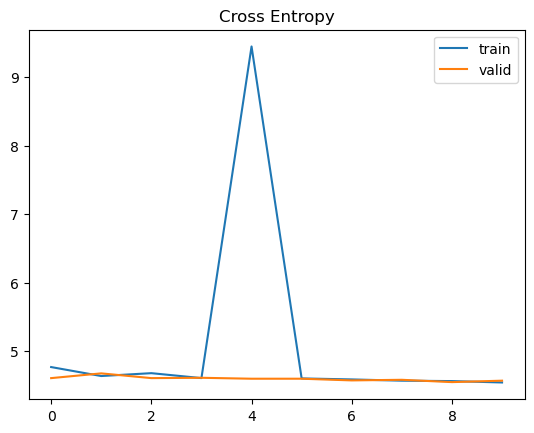

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

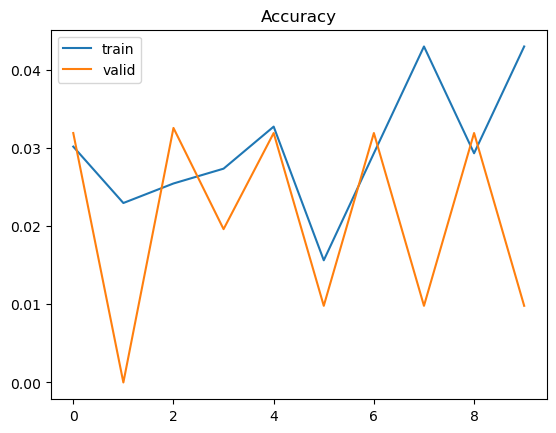

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

<a id="section3.4"></a>
# <font color="#004D7F" size=5>Data Augmentation</font>



* Primero, en el constructor definimos las operaciones o modificaciones que vamos a realizar a los datos.
* Segundo, con las funciones `flow` generamos un iterador que se va a encargar de leer los datos. Por eso los parámetros de entrada de las funciones `flow` indican donde se encuentran las imágenes, el formato de estas y el tamaño de salida. También indicamos aquí el tamaño del batch del iterador.

Con esto el iterador obtenido primero cargará el batch de datos según lo indicado en los parámetros de las funicones `flow` y luego aplicará las funciones definidas en el constructor de [`ImageDataGenerator`](https://keras.io/preprocessing/image/). Estas funciones consisten en data augmentation estocástico, es decir, cada operación que se ha indicado se aplica de forma aleatoria a las diferentes datos, en este caso imágenes, de los batches.

In [45]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=15, shear_range=0.2, zoom_range=0.2)

train_iter_augmented = train_datagen_augmented.flow_from_dataframe(
    train_frame, x_col='files', y_col='labels', target_size=(100, 120), class_mode='categorical',
    batch_size=32, shuffle=True)

Found 4913 validated image filenames belonging to 102 classes.


In [46]:

# Definimos el modelo
model = Sequential()

# Primer bloque convolucional
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Segundo bloque convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Tercer bloque convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Cuarto bloque convolucional
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Aplanar y agregar capas densas
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(102, activation='softmax'))

# Programar la tasa de aprendizaje
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)

# Configuración del optimizador
optimizer = Adam(learning_rate=lr_schedule)

# Compilación del modelo
model.compile(
    loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    train_iter_augmented,
    steps_per_epoch=train_frame.shape[0] // train_iter_augmented.batch_size,
    epochs=20, validation_data=valid_iter,
    validation_steps=valid_frame.shape[0] // valid_iter.batch_size)

C:\Users\Lea\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\Lea\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 98s 593ms/step - accuracy: 0.0258 - loss: 4.5798 - val_accuracy: 0.0775 - val_loss: 4.2385
Epoch 2/20
  1/153 ━━━━━━━━━━━━━━━━━━━━ 48s 320ms/step - accuracy: 0.0312 - loss: 4.2892

C:\Users\Lea\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0312 - loss: 4.2892 - val_accuracy: 0.0196 - val_loss: 4.2599
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 89s 572ms/step - accuracy: 0.0579 - loss: 4.1527 - val_accuracy: 0.1217 - val_loss: 3.8476
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 4.0657 - val_accuracy: 0.0392 - val_loss: 3.7793
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 539ms/step - accuracy: 0.0914 - loss: 3.8134 - val_accuracy: 0.1439 - val_loss: 3.6360
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 3.7949 - val_accuracy: 0.0784 - val_loss: 3.6862
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 85s 546ms/step - accuracy: 0.1347 - loss: 3.5042 - val_accuracy: 0.1914 - val_loss: 3.1918
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1875 - loss: 3.2738 - val_accuracy: 0.1176 - val_loss: 3.2989
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 541ms/step - accuracy: 0.1775 - loss: 3.2410 - val_acc

In [47]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3744 - loss: 2.4007
loss en validación: 2.4053642749786377 
accuracy en validación: 0.3763020932674408
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3556 - loss: 2.4249
loss en test: 2.422506093978882 
accuracy en test: 0.3548177182674408


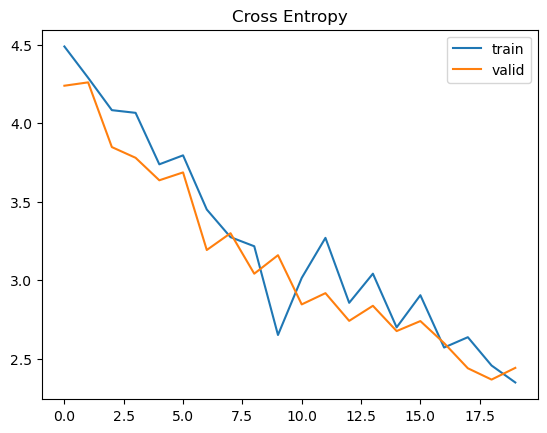

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

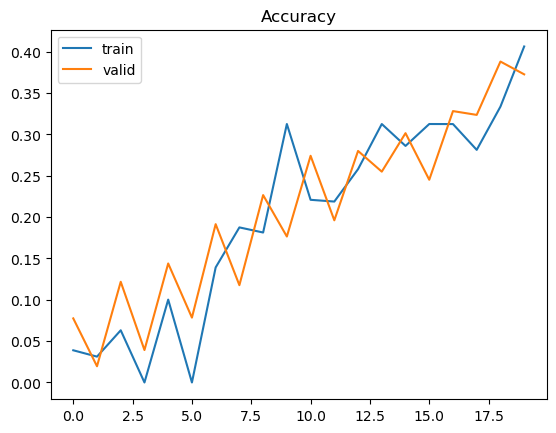

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


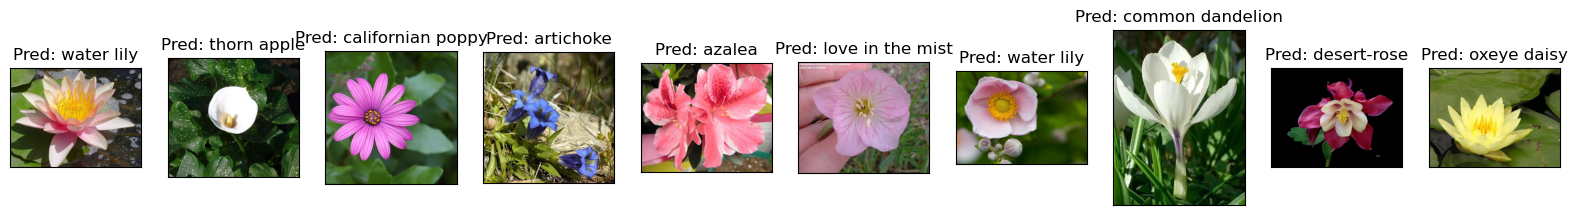

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Realizar predicciones en el conjunto de prueba
predictions_prob = model.predict(test_iter, steps=test_frame.shape[0] // test_iter.batch_size)

# Convertir las probabilidades en predicciones de clase
predictions = np.argmax(predictions_prob, axis=1)

# Seleccionar aleatoriamente 10 índices del conjunto de prueba
indices = np.random.randint(len(test_files), size=10)

# Preparar la figura para graficar
fig = plt.figure(figsize=(20, 8))

 num_classes = len(names)  

for i in range(10):   
    ax = fig.add_subplot(1, 10, i + 1)
    
    # Cargar y mostrar la imagen
    img = plt.imread(test_files[indices[i]])
    ax.imshow(img)
    
    # Eliminar los ticks de los ejes
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Obtener la etiqueta predicha
    pred_idx = predictions[indices[i]]
    if pred_idx < num_classes:  # Verificar si el índice es válido
        predicted_label = names[pred_idx]
    else:
        predicted_label = "Desconocido"
    
    # Establecer el título con la etiqueta predicha
    ax.set_title(f"Pred: {predicted_label}")

plt.show()